# The Battle of Neighbourhoods

### Clustering London Venues and Analysing Correlations to Property Prices

In [1]:
# Installing requried packages
!pip install folium
!pip install geopy

     |████████████████████████████████| 92kB 4.3MB/s eta 0:00:01


In [2]:
# Importing requried libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import requests

### Part 1:

London needs to be split into relevant regions in order to compare the distribution of venues and their correlation to property prices. The city is already conveniently sectioned into postcodes with clearly defined boundaries and addresses. 

A csv list of the UK's district postcodes used in this notebook, including their comprised neighbourhoods, can be found at: https://www.doogal.co.uk/PostcodeDistricts.php

In [3]:
# Reading CSV of UK Districts into a pandas dataframe
UK_Postcodes = pd.read_csv('https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx')
UK_Postcodes.head()

,Postcode,Latitude,Longitude,Easting,Northing,Grid Reference,Town/Area,Region,Postcodes,Active postcodes,Population,Households,Nearby districts
0,AB1,57.1269,-2.13644,391839.0,804005.0,NJ918040,Aberdeen,Aberdeen,2655.0,0.0,NaN,NaN,"AB10, AB15, AB9, AB25, AB2, AB12, AB16, AB11, ..."
1,AB2,57.1713,-2.14152,391541.0,808948.0,NJ915089,Aberdeen,Aberdeen,3070.0,0.0,NaN,NaN,"AB16, AB22, AB24, AB25, AB1, AB9, AB15, AB10, ..."
2,AB3,57.0876,-2.59624,363963.0,799780.0,NO639997,Aberdeen,Aberdeen,2168.0,0.0,NaN,NaN,"AB31, AB34, AB52, AB33, AB14, AB32, AB30, AB13..."
3,AB4,57.5343,-2.12713,392487.0,849358.0,NJ924493,"Fraserburgh, Peterhead, Macduff",Aberdeen,2956.0,0.0,NaN,NaN,"AB41, AB43, AB42, AB53, AB22, AB23, AB2, AB24,..."
4,AB5,57.4652,-2.64764,361248.0,841843.0,NJ612418,"Buckie, Huntly, Inverurie",Aberdeen,3002.0,0.0,NaN,NaN,"AB54, AB52, AB45, AB53, AB33, AB44, AB55, AB51..."


In [4]:
# Removing columns that won't be needed
UK_Postcodes.drop(axis = 1, columns = ['Easting', 'Northing', 'Grid Reference', 'Postcodes', 'Active postcodes', 'Population', 'Households', 'Nearby districts'], inplace = True)

The "UK_Postcodes" dataframe created includes all the postcodes in the UK. We will need to extract the postcodes in London only. Luckily, all London postcodes start with N, E, SE, SW or W.

In [5]:
# Taking the postcodes that start with N, E, S or W 
regions = ['N', 'E', 'SE', 'SW', 'W']
London_Postcodes = pd.DataFrame([])
for region in regions:
    temp = UK_Postcodes[(UK_Postcodes['Postcode'].str.startswith(region))]
    London_Postcodes = London_Postcodes.append(temp)

In [6]:
# Deleting UK postcodes that also start with N, E, S and W but that are not in London
regions = ['WS', 'NE', 'WR', 'WV', 'EX', 'EN', 'EH', 'NG', 'WF', 'WN', 'WD', 'NN', 'WA', 'NP', 'NR']
for region in regions:
    indexnames = London_Postcodes[(London_Postcodes['Postcode'].str.startswith(region))].index
    London_Postcodes.drop(indexnames, inplace = True)

In [7]:
# Deleting "Non-geographic" postcodes
indexnames = London_Postcodes[(London_Postcodes['Town/Area'].str.contains('Non-geographic'))].index
London_Postcodes.drop(indexnames, inplace = True)

In [8]:
# Deleting sudivided central london postcodes (i.e. WC99, N1C and E1W)
regions = ['WC99', 'N1C', 'E1W']
for region in regions:
    indexnames = London_Postcodes[(London_Postcodes['Postcode'] == region)].index
    London_Postcodes.drop(indexnames, inplace = True)

The London Postcodes have now been extracted. However, central london postcodes (WC1, WC2, WC3, WC4, W1, SW1, EC1 and EC2) in our data set are split into subdivided sections. For example W1 is subdivided into 14 sub-ditricts W1A, W1B, W1C, etc... This could become a problem when defining regions for venues using the foursquare API later on in the analaysis since the subdivisions produce much smaller regions than the larger district postcodes. Therefore, the accuracy can be improved by grouping these subdivisions into their larger central london postcodes and using the co-ordinates of their centers, i.e. by grouping the subdivisons into WC1, WC2, WC3, WC4, W1, SW1, EC1 and EC2.

It seems easier to do this by deleting all the subdivided regions from the dataframe and adding in the information manually by finding the co-ordinates and areas of each district on the internet. For example all the information for EC1, EC2, EC3 and EC4 can be found under the "boundaries" heading here: https://en.wikipedia.org/wiki/EC_postcode_area

In [9]:
# Deleting central london postcode subdivisions
regions = ['WC1', 'WC2', 'EC1', 'EC2', 'EC3', 'EC4']
for region in regions:
    indexnames = London_Postcodes[(London_Postcodes['Postcode'].str.startswith(region))].index
    London_Postcodes.drop(indexnames, inplace = True)

In [10]:
# Deleting central london postcode subdivisions
regions = ['SW1A', 'SW1B', 'SW1E', 'SW1H', 'SW1P', 'SW1V', 'SW1W', 'SW1X', 'SW1Y',
           'W1A', 'W1B', 'W1C', 'W1D', 'W1F', 'W1M', 'W1N', 'W1P', 'W1R',  'W1V', 'W1X', 'W1M', 'W1Y', 'W1G', 'W1H', 'W1J', 'W1K', 'W1S', 'W1T', 'W1U', 'W1W']
for region in regions:
    indexnames = London_Postcodes[(London_Postcodes['Postcode'] == region)].index
    London_Postcodes.drop(indexnames, inplace = True)

In [11]:
# Adding rows for central london distrcits WC1, WC2, WC3, WC4, W1, SW1, EC1 and EC2
temp = [pd.Series(['EC1', '51.523', '-0.092000', 'City of London, Islington, Camden, Hackney', 'Eastern Central'], index = London_Postcodes.columns) ,
        pd.Series(['EC2', '51.518', '-0.084000', 'Islington, Hackney, City of London, Tower Hamlets', 'Eastern Central'], index = London_Postcodes.columns) ,
        pd.Series(['EC3', '51.508', '-0.076000', 'Tower Hamlets, City of London', 'Eastern Central'], index = London_Postcodes.columns) ,
        pd.Series(['EC4', '51.511', '-0.098000', 'City of London, Westminster', 'Eastern Central'], index = London_Postcodes.columns) ,
        pd.Series(['WC1', '51.514', '-0.120000', 'Camden, City of London, Islington', 'Western Central'], index = London_Postcodes.columns) ,
        pd.Series(['WC2', '51.514', '-0.124000', 'Camden, Westminster, City of London', 'Western Central'], index = London_Postcodes.columns) ,
        pd.Series(['SW1', '51.503', '-0.131000', 'Westminster, Kensington and Chelsea', 'South West Central'], index = London_Postcodes.columns) ,
        pd.Series(['W1', '51.516', '-0.140000', 'Westminster, Camden', 'West Central'], index = London_Postcodes.columns) ,]

london = London_Postcodes.append(temp , ignore_index=True)

In [12]:
london.rename(index=str, columns={"Town/Area": "Neighborhood"}, inplace = True)

In [13]:
london[(london['Postcode'].str.startswith('E'))]

,Postcode,Latitude,Longitude,Neighborhood,Region
33,E1,51.5163,-0.0604063,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets
34,E2,51.5301,-0.0622545,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets
35,E3,51.5281,-0.0258847,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets
36,E4,51.6238,-0.00326787,"Chingford, Sewardstone, Highams Park",Waltham Forest
37,E5,51.5593,-0.0545246,"Upper Clapton, Lower Clapton, Leyton, Stoke Ne...",Hackney
38,E6,51.5252,0.0551478,"East Ham, Beckton, Upton Park, Barking",Newham
39,E7,51.5476,0.0261657,"Forest Gate, Stratford",Newham
40,E8,51.5413,-0.0650412,"Hackney Central, Dalston, London Fields",Hackney
41,E9,51.5419,-0.0465518,"Homerton, Hackney Wick, South Hackney, Hackney...",Hackney
42,E10,51.5687,-0.0127665,"Leyton, Temple Mills, Hackney Marshes, Upper C...",Hackney


In [14]:
london.shape

(120, 5)

In [15]:
london.head(10)

,Postcode,Latitude,Longitude,Neighborhood,Region
0,N1,51.5376,-0.0982609,"Barnsbury, Canonbury, Kings Cross, Islington, ...",Hackney
1,N2,51.5903,-0.168663,"East Finchley, Fortis Green, Hampstead Garden ...",Barnet
2,N3,51.6004,-0.194107,"Finchley, Church End, Finchley Central",Barnet
3,N4,51.5711,-0.103982,"Finsbury Park, Manor House, Harringay, Stroud ...",Haringey
4,N5,51.5538,-0.0985845,"Highbury, Highbury Fields",Islington
5,N6,51.5715,-0.140822,"Highgate, Hampstead Heath",Camden
6,N7,51.5537,-0.117979,"Holloway, Barnsbury, Islington, Tufnell Park",Islington
7,N8,51.5823,-0.120137,"Hornsey, Crouch End, Harringay",Haringey
8,N9,51.6278,-0.0587701,"Lower Edmonton, Edmonton",Enfield
9,N10,51.5939,-0.144311,Muswell Hill,Haringey


The 'london' dataset above now comprises all 120 postcode districts in london, including the Longititude and Latitude co-ordinates of their centers. This dataset is now ready for analysis and we can move on the part 2.

### Part 2:

A list of venues in range of each borough will be required for clustering. This will be done using the Foursquare API and querying within a defined radius from the center of each Postcode in the london dataset above.

In [16]:
# Defining Foursquare Credentials
CLIENT_ID = 'YOUR FOURSQUARE ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR FOURSQUARE SECRET' # your Foursquare Secret
VERSION = '20180604'

In [17]:
# Obtaining co-ordinates of London
address = 'London, ldn'

geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.4546664, -0.0370617.


In [18]:
# Defining a function that returns all venues within a 1000m radius of each neighborhood from the Foursquare API and put them into a DataFrame
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# Getting the top 100 nearby venues for all Neighborhoods in Toronto and producing a pandas Dataframe
LIMIT = 200
london_venues = getNearbyVenues(names=london['Neighborhood'],
                                   latitudes=london['Latitude'],
                                   longitudes=london['Longitude']
                                  )

Barnsbury, Canonbury, Kings Cross, Islington, Pentonville, De Beauvoir Town, Hoxton
East Finchley, Fortis Green, Hampstead Garden Suburb
Finchley, Church End, Finchley Central
Finsbury Park, Manor House, Harringay, Stroud Green
Highbury, Highbury Fields
Highgate, Hampstead Heath
Holloway, Barnsbury, Islington, Tufnell Park
Hornsey, Crouch End, Harringay
Lower Edmonton, Edmonton
Muswell Hill
New Southgate, Friern Barnet, Bounds Green, Arnos Grove
North Finchley, Woodside Park
Palmers Green
Southgate, Oakwood, Arnos Grove
West Green, Seven Sisters, Duckett's Green
Stoke Newington, Stamford Hill, Shacklewell, Dalston, Newington Green
Tottenham, South Tottenham
Upper Edmonton, Edmonton
Upper Holloway, Archway, Tufnell Park, Hornsey
Whetstone, Totteridge, Oakleigh Park
Winchmore Hill, Bush Hill, Grange Park
Wood Green, Bounds Green, Bowes Park
Euston, Camden Town, Somers Town, Primrose Hill, Gospel Oak, Lisson Grove
Cricklewood, Willesden, Neasden, Dollis Hill, Childs Hill
Hampstead, Chalk 

In [20]:
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982609,Steve Hatt,51.538588,-0.099041,Fish Market
1,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982609,The Life Centre Islington,51.538056,-0.099171,Yoga Studio
2,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982609,The Bill Murray,51.536226,-0.098750,Pub
3,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982609,Pophams,51.536666,-0.096175,Bakery
4,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982609,Saponara,51.536875,-0.096121,Italian Restaurant


In [21]:
london_venues.shape

(8048, 7)

In [22]:
# One hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# Adding neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# Moving neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

# Grouping by mean and frequency of occurence
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,"Abbey Wood, West Heath, Crossness, Thamesmead",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0
1,"Acton, East Acton, Park Royal, West Acton",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020408,0.0,0.00,0.0,0.0,0.020408,0.0
2,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.0
3,"Anerley, Crystal Palace, Penge, Beckenham",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0
4,"Balham, Clapham South, Hyde Farm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010638,0.0,0.00,0.0,0.0,0.010638,0.0


In [23]:
# Defining a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
# Creating a Dataframe to display the top 10 venues of each Neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Wood, West Heath, Crossness, Thamesmead",Supermarket,Furniture / Home Store,Campground,Train Station,Convenience Store,Historic Site,Grocery Store,Coffee Shop,Fast Food Restaurant,Filipino Restaurant
1,"Acton, East Acton, Park Royal, West Acton",Pub,Gym / Fitness Center,Grocery Store,Train Station,Platform,Coffee Shop,Park,Breakfast Spot,Hotel,Gas Station
2,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Coffee Shop,Hotel,Pub,Indian Restaurant,Pizza Place,Café,Bar,Turkish Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
3,"Anerley, Crystal Palace, Penge, Beckenham",Pub,Grocery Store,Park,Supermarket,Pizza Place,Café,Fast Food Restaurant,Coffee Shop,Convenience Store,Train Station
4,"Balham, Clapham South, Hyde Farm",Coffee Shop,Pub,Pizza Place,Bakery,Grocery Store,Indian Restaurant,Bar,Café,Steakhouse,Supermarket


In [25]:
# dropping neighborhood column from grouped table to prepare for K-means clustering algorithm
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

In [26]:
# running k-means clustering for diferent numbers of clusters to find the optimum value of 'k'
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [27]:
# Importing visualisation packages
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

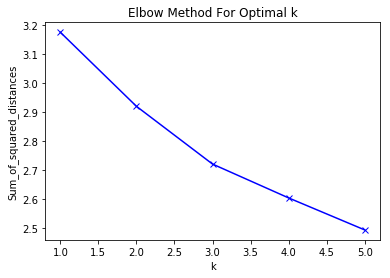

In [28]:
# visualising the otimum number of 'k' i.e. the elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [101]:
# Clustering the Neighborhoods into 3 clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

In [102]:
# Adding clustering labels
neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [103]:
london_merged = london

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [104]:
london_merged = london_merged.dropna()
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged['Latitude'] = london_merged['Latitude'].astype(float)
london_merged['Longitude'] = london_merged['Longitude'].astype(float)
london_merged.head(10)

,Postcode,Latitude,Longitude,Neighborhood,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,N1,51.5376,-0.098261,"Barnsbury, Canonbury, Kings Cross, Islington, ...",Hackney,0,Pub,French Restaurant,Gastropub,Mediterranean Restaurant,Boutique,Coffee Shop,Burger Joint,Japanese Restaurant,Fish Market,Furniture / Home Store
1,N2,51.5903,-0.168663,"East Finchley, Fortis Green, Hampstead Garden ...",Barnet,2,Pub,Café,Coffee Shop,Park,Grocery Store,Indian Restaurant,Pizza Place,Bakery,Platform,Bus Stop
2,N3,51.6004,-0.194107,"Finchley, Church End, Finchley Central",Barnet,2,Turkish Restaurant,Café,Indian Restaurant,Pizza Place,Fast Food Restaurant,Convenience Store,Coffee Shop,Restaurant,Park,Japanese Restaurant
3,N4,51.5711,-0.103982,"Finsbury Park, Manor House, Harringay, Stroud ...",Haringey,2,Pub,Turkish Restaurant,Café,Pizza Place,Coffee Shop,Sandwich Place,Grocery Store,Indian Restaurant,Gym / Fitness Center,Italian Restaurant
4,N5,51.5538,-0.098585,"Highbury, Highbury Fields",Islington,2,Café,Pub,Turkish Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Park,Restaurant,Seafood Restaurant
5,N6,51.5715,-0.140822,"Highgate, Hampstead Heath",Camden,2,Pub,Coffee Shop,Café,Bus Stop,Trail,Indian Restaurant,Italian Restaurant,Grocery Store,Pizza Place,Bakery
6,N7,51.5537,-0.117979,"Holloway, Barnsbury, Islington, Tufnell Park",Islington,2,Café,Pub,Gym / Fitness Center,Coffee Shop,Grocery Store,Bar,Ethiopian Restaurant,Park,Breakfast Spot,French Restaurant
7,N8,51.5823,-0.120137,"Hornsey, Crouch End, Harringay",Haringey,2,Pub,Café,Coffee Shop,Bakery,Thai Restaurant,Bus Stop,Gym / Fitness Center,Grocery Store,Indie Movie Theater,Park
8,N9,51.6278,-0.058770,"Lower Edmonton, Edmonton",Enfield,1,Turkish Restaurant,Coffee Shop,Hotel,Gym / Fitness Center,Supermarket,Middle Eastern Restaurant,Fast Food Restaurant,Shopping Mall,Discount Store,Bus Station
9,N10,51.5939,-0.144311,Muswell Hill,Haringey,2,Café,Pub,Coffee Shop,Deli / Bodega,Restaurant,Pizza Place,Bus Stop,English Restaurant,Playground,Bar


In [105]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
color_array = ['blue', 'green', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, post in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels'], london_merged['Postcode']):
    label = folium.Popup(str(post) + ' ' + str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=color_array[cluster],
        fill=True,
        fill_color=color_array[cluster],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

In [106]:
london_grouped.shape

(120, 377)

In [107]:
london_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,"Abbey Wood, West Heath, Crossness, Thamesmead",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0
1,"Acton, East Acton, Park Royal, West Acton",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020408,0.0,0.00,0.0,0.0,0.020408,0.0
2,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.0
3,"Anerley, Crystal Palace, Penge, Beckenham",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0
4,"Balham, Clapham South, Hyde Farm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010638,0.0,0.00,0.0,0.0,0.010638,0.0


In [108]:
cluster0 = london_merged.loc[london_merged['Cluster Labels'] == 0]

In [109]:
cluster1 = london_merged.loc[london_merged['Cluster Labels'] == 1]

In [110]:
cluster2 = london_merged.loc[london_merged['Cluster Labels'] == 2]

In [111]:
cluster_0 = cluster0.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])

In [112]:
cluster_0.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pub,French Restaurant,Gastropub,Mediterranean Restaurant,Boutique,Coffee Shop,Burger Joint,Japanese Restaurant,Fish Market,Furniture / Home Store
20,Italian Restaurant,Bar,Train Station,Coffee Shop,Playground,Bistro,Middle Eastern Restaurant,English Restaurant,Mobile Phone Shop,Pizza Place
22,Zoo Exhibit,Coffee Shop,Music Venue,Beer Bar,Burger Joint,Pub,Garden,Café,Theater,Lounge
32,Coffee Shop,Bakery,Grocery Store,Café,Turkish Restaurant,Korean Restaurant,Sushi Restaurant,Supermarket,Italian Restaurant,Stationery Store
33,Coffee Shop,Hotel,Pub,Indian Restaurant,Pizza Place,Café,Bar,Turkish Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant


In [113]:
# Transforming the Dataframe into a count of venues
count_venues = pd.crosstab(**cluster_0.melt(var_name='columns', value_name='index'))
count_venues.head()

columns,10th Most Common Venue,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
index,,,,,,,,,,
Art Gallery,0,0,0,0,0,0,2,1,1,0
Art Museum,0,0,0,0,0,0,2,0,0,0
Asian Restaurant,0,0,0,0,0,0,0,0,1,1
Auto Garage,0,0,0,0,0,0,0,0,0,1
Bakery,0,1,2,1,0,1,3,3,0,2


In [114]:
# Creating a new Dataframe of the sum of the venues
count_0 = pd.DataFrame(count_venues.sum(axis=1))
count_0.head()

,0
index,
Art Gallery,4
Art Museum,2
Asian Restaurant,2
Auto Garage,1
Bakery,13


In [115]:
# Renaming the columns, sorting by count and computing as a percentage of the total i.e. calculating the distribution of venues for cluster 0
count_0.columns = ['Count']
count_0.index.names = ['Venue']
count_0['Percentage of Total'] = (count_0['Count']/count_0['Count'].sum())*100
count_0.sort_values(['Count'], ascending = False, inplace = True)
count_0.drop('Count', axis=1, inplace = True)
count_0.head(20)

,Percentage of Total
Venue,
Coffee Shop,7.5000
Pub,6.2500
Hotel,5.3125
Café,5.3125
Italian Restaurant,5.0000
Restaurant,4.3750
Bakery,4.0625
Pizza Place,3.4375
Gym / Fitness Center,3.4375


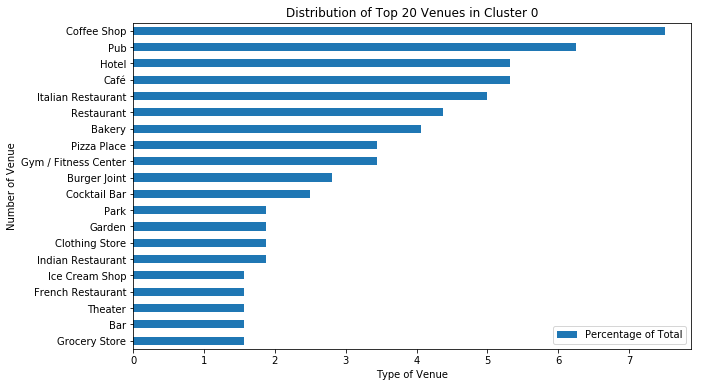

In [116]:
C0_top20 = count_0.head(20)
C0_top20.plot.barh(figsize=(10, 6))
plt.gca().invert_yaxis()

plt.title('Distribution of Top 20 Venues in Cluster 0')
plt.ylabel('Number of Venue')
plt.xlabel('Type of Venue')

plt.show()

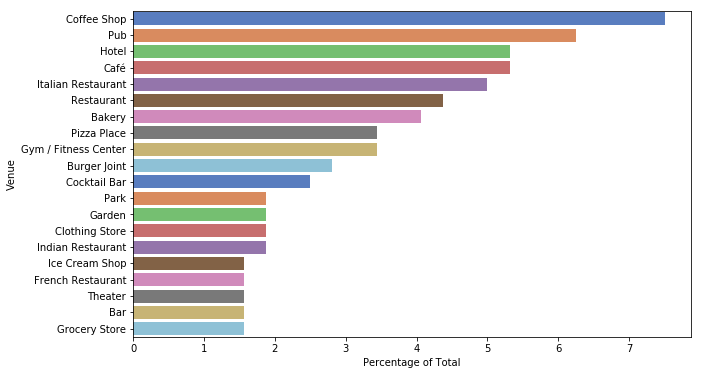

In [117]:
C0_top20 = count_0.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y = C0_top20.index, x = C0_top20['Percentage of Total'], palette = 'muted')

In [118]:
# calculating the distribution of venues for cluster 1
cluster_1 = cluster1.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])
count_venues = pd.crosstab(**cluster_1.melt(var_name='columns', value_name='index'))
count_1 = pd.DataFrame(count_venues.sum(axis=1))
count_1.columns = ['Count']
count_1.index.names = ['Venue']
count_1['Percentage of Total'] = (count_1['Count']/count_1['Count'].sum())*100
count_1.sort_values(['Count'], ascending = False, inplace = True)
count_1.drop('Count', axis=1, inplace = True)

In [119]:
# calculating the distribution of venues for cluster 2
cluster_2 = cluster2.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])
count_venues = pd.crosstab(**cluster_2.melt(var_name='columns', value_name='index'))
count_2 = pd.DataFrame(count_venues.sum(axis=1))
count_2.columns = ['Count']
count_2.index.names = ['Venue']
count_2['Percentage of Total'] = (count_2['Count']/count_2['Count'].sum())*100
count_2.sort_values(['Count'], ascending = False, inplace = True)
count_2.drop('Count', axis=1, inplace = True)

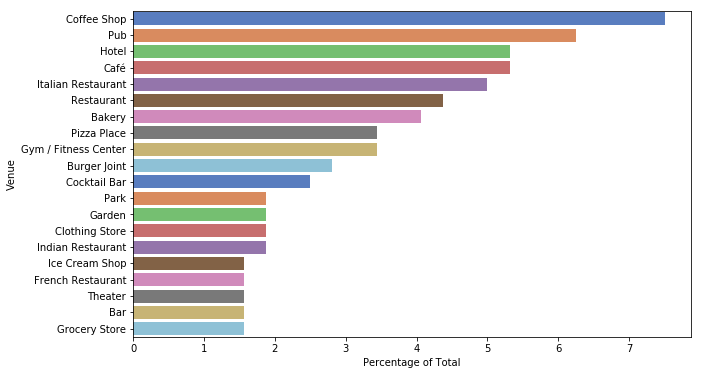

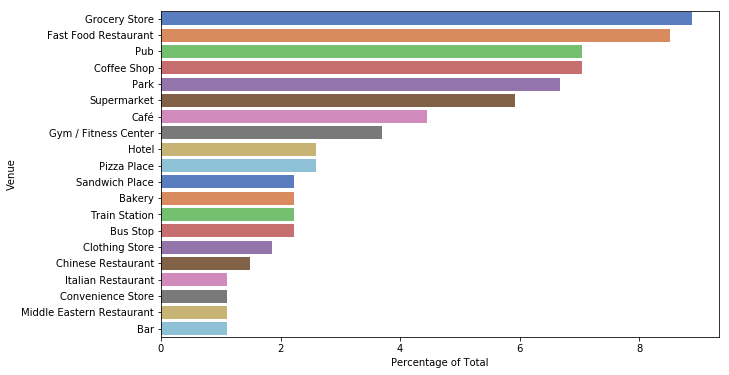

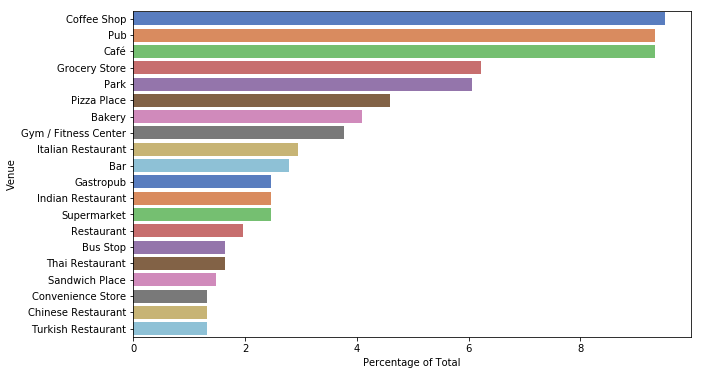

In [120]:
# visualizing the distributions as line graphs

C0_top20 = count_0.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y = C0_top20.index, x = C0_top20['Percentage of Total'], palette = 'muted')

C1_top20 = count_1.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y = C1_top20.index, x = C1_top20['Percentage of Total'], palette = 'muted')

C2_top20 = count_2.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y = C2_top20.index, x = C2_top20['Percentage of Total'], palette = 'muted')

plt.show()

## PART 3

In [121]:
# Reading csv of Average Property Prices by postcode extracted from Zoopla.com
properties = pd.read_excel('https://github.com/Moftos/The_Battle_of_Neighborhoods/blob/master/Postcode%20Property%20Values.xlsx?raw=true', index_col = 0)

In [122]:
properties.head(5)

,Avg. paid prices
Outcode,
E1,559558
E10,441798
E11,567596
E12,428831
E13,366825


In [123]:
# Seperating the prices by clusters i.e. creating 3 dataframes of postcodes in each cluster with the average property prices of those postcodes
value_cluster_0 = properties[properties.index.isin(cluster0['Postcode'])]
value_cluster_1 = properties[properties.index.isin(cluster1['Postcode'])]
value_cluster_2 = properties[properties.index.isin(cluster2['Postcode'])]

In [124]:
print(value_cluster_0.describe())
print(value_cluster_1.describe())
print(value_cluster_2.describe())

       Avg. paid prices
count      3.200000e+01
mean       1.099067e+06
std        6.593538e+05
min        3.924430e+05
25%        6.591375e+05
50%        8.306210e+05
75%        1.288613e+06
max        2.705424e+06
       Avg. paid prices
count         27.000000
mean      512152.481481
std       137712.069720
min       279229.000000
25%       422180.500000
50%       467341.000000
75%       647738.500000
max       759981.000000
       Avg. paid prices
count      6.100000e+01
mean       7.075273e+05
std        3.000216e+05
min        3.488620e+05
25%        5.159550e+05
50%        6.059260e+05
75%        8.216390e+05
max        2.046685e+06


In [125]:
print(value_cluster_0.mean())
print(value_cluster_1.mean())
print(value_cluster_2.mean())

Avg. paid prices    1.099067e+06
dtype: float64
Avg. paid prices    512152.481481
dtype: float64
Avg. paid prices    707527.262295
dtype: float64


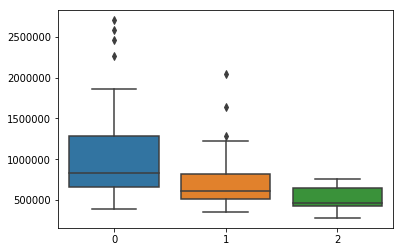

In [126]:
sns.boxplot(data = [value_cluster_0, value_cluster_2, value_cluster_1])